In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from lmfit import Parameters, minimize
import matplotlib.pyplot as plt
import math
from py_vollib_vectorized import vectorized_implied_volatility as iv
import time

In [2]:
i = complex(0,1)

# Question 1

In [4]:
# Support function
def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):
    prod = rho * sigma * i *s 
    
    # Compute d
    d1, d2 = (prod - kappa)**2, (sigma**2) * (i*s + s**2)
    d = np.sqrt(d1 + d2)
    
    # Compute g
    g1, g2 = kappa - prod - d, kappa - prod + d
    g = g1/g2
    
    # Compute first exponential
    exp1, exp2, exp3 = np.exp(np.log(St) * i *s) * np.exp(i * s * r * T), 1 - g * np.exp(-d * T), 1 - g
    mainExp1 = exp1 * np.power(exp2/ exp3, -2 * theta * kappa/(sigma **2))
    
    # Compute second exponential
    exp4, exp5, exp6 = theta * kappa * T/(sigma**2), volvol/(sigma **2), (1 - np.exp(-d * T))/(1 - g * np.exp(-d * T))
    mainExp2 = np.exp((exp4 * g1) + (exp5 * g1 * exp6))
    
    return (mainExp1 * mainExp2)

# Heston Pricer
def priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0, 1000, 100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
    # Calculate the complex integral
    for j in range(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) * i * s1
        
        P = P + ds * (numerator1 - numerator2)/denominator
    
    element2 = P/np.pi
    
    return np.real((element1 + element2))

In [5]:
# Parameters of the dataset
maturity, S0, r = 1/26, 5200, 0

In [6]:
# Import the dataset
df = pd.read_csv("SPX_2_weeks.csv")
df = df[df["Type"] == "Call"]

df["Strike"] = df["Strike"].str.replace(",", "").astype(float)
df["Mid"] = df["Mid"].str.replace(",", "").astype(float)

In [7]:
df

,Strike,Moneyness,Bid,Mid,Ask,Last,Change,%Chg,Volume,Open Int,OI Chg,Delta,IV,Type,Time
0,2200.0,+57.59%,"2,978.90",2986.25,"2,993.60",0.00,unch,unch,0.0,0,unch,0.99128,201.07%,Call,NaN
1,2400.0,+53.73%,"2,779.30",2786.80,"2,794.30",0.00,unch,unch,0.0,0,unch,0.98997,183.61%,Call,NaN
2,2600.0,+49.88%,"2,580.50",2587.35,"2,594.20",0.00,unch,unch,0.0,0,unch,0.98943,164.67%,Call,NaN
3,2800.0,+46.02%,"2,380.50",2388.15,"2,395.80",0.00,unch,unch,0.0,0,unch,0.99897,105.79%,Call,NaN
4,3000.0,+42.16%,"2,181.60",2188.50,"2,195.40",0.00,unch,unch,0.0,0,unch,0.99880,95.12%,Call,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,6600.0,-27.24%,0.00,0.23,0.45,0.15,unch,unch,0.0,3,unch,0.00187,41.66%,Call,03/27/25
202,6800.0,-31.09%,0.00,0.20,0.40,0.28,unch,unch,0.0,1,unch,0.00154,45.83%,Call,04/07/25
203,7000.0,-34.95%,0.00,0.20,0.40,0.00,unch,unch,0.0,0,unch,0.00141,50.25%,Call,NaN
204,7200.0,-38.81%,0.00,0.18,0.35,0.00,unch,unch,0.0,0,unch,0.00117,53.91%,Call,NaN


In [8]:
# Parameters for optimization
strikes, marketPrices = df["Strike"][50:190].to_numpy(), df["Mid"][50:190].to_numpy()

In [9]:
# This is the calibration function
def calibratorHeston(St, initialValues = [0.2,0.05,0.2,0.8,-0.7], lowerBounds = [1e-2,1e-2,1e-2,1e-2,-1], upperBounds = [10,10,10,10,1]):
    
    params = Parameters()
    params.add('sigma',value = initialValues[0], min = lowerBounds[0], max = upperBounds[0])
    params.add('kappa',value = initialValues[1], min = lowerBounds[1], max = upperBounds[1])
    params.add('theta',value = initialValues[2], min = lowerBounds[2], max = upperBounds[2])
    params.add('volvol', value = initialValues[3], min = lowerBounds[3], max = upperBounds[3])
    params.add('rho', value = initialValues[4], min = lowerBounds[4], max = upperBounds[4])
    
    objectiveFunctionHeston = lambda paramVect: (marketPrices - priceHestonMid(St, strikes, r, maturity, paramVect['sigma'].value, 
                                                                                                         paramVect['kappa'].value, 
                                                                                                         paramVect['theta'].value, 
                                                                                                         paramVect['volvol'].value, 
                                                                                                         paramVect['rho'].value)) / marketPrices   
    
    result = minimize(objectiveFunctionHeston, params, method = 'leastsq', ftol = 1e-15)
    
    return(result)

start = time.time()
fit = calibratorHeston(S0)
end = time.time()

print(f"Time to calibrate: {end - start:.2f} seconds\n")

Time to calibrate: 75.48 seconds



In [10]:
fit

In [11]:
sigma, kappa, theta, volvol, rho = fit.params['sigma'].value, fit.params['kappa'].value, fit.params['theta'].value, fit.params['volvol'].value, fit.params['rho'].value

# Compute model prices
modelPrices = priceHestonMid(S0, strikes, r, maturity, sigma, kappa, theta, volvol, rho)

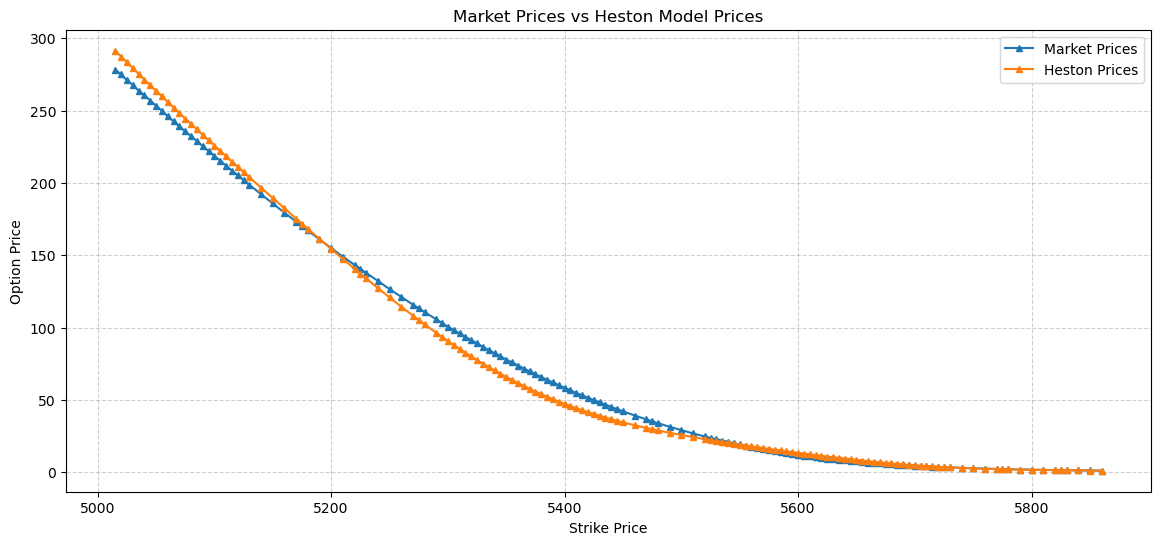

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(strikes, marketPrices, marker='^', linestyle='-', label="Market Prices", markersize=5)
plt.plot(strikes, modelPrices,  marker='^', linestyle='-', label="Heston Prices", markersize=5)
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Market Prices vs Heston Model Prices")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [13]:
# Compute the IV
iv_market = iv(marketPrices[:], S0, strikes[:], maturity, r, 'c', return_as='numpy')
iv_heston = iv(modelPrices[:], S0, strikes[:], maturity, r, 'c', return_as='numpy')

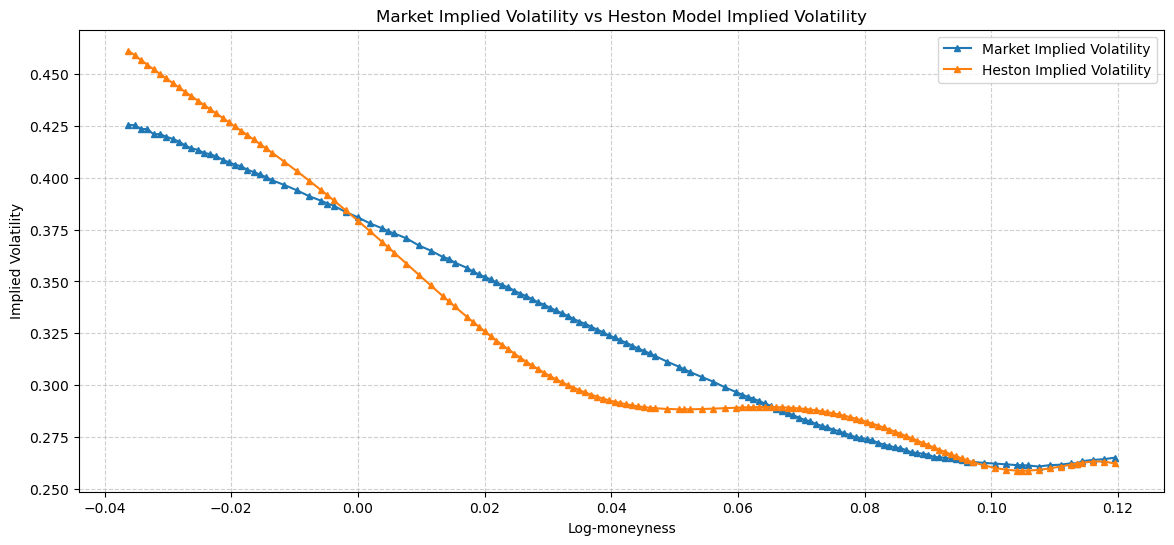

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(np.log(strikes[:]/S0), iv_market, marker='^', linestyle='-', label="Market Implied Volatility", markersize=5)
plt.plot(np.log(strikes[:]/S0), iv_heston, marker='^', linestyle='-', label="Heston Implied Volatility", markersize=5)
plt.xlabel("Log-moneyness")
plt.ylabel("Implied Volatility")
plt.title("Market Implied Volatility vs Heston Model Implied Volatility")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Question 2

In [16]:
# Parameters for optimization
strikes, marketPrices = df["Strike"][50:180].to_numpy(), df["Mid"][50:180].to_numpy()

In [17]:
# Lifted Heston model from exercise 2
alpha, alpha2, M, L = 0.7, 1, 100, 100
strikes = strikes.reshape(-1, 1)

def compute_c(r, n, alpha):
    c = np.array([(r**(1 - alpha) - 1) * (r**((1 - alpha) * (ii - 1 - n / 2))) / (math.gamma(alpha) * math.gamma(2 - alpha)) for ii in range(1, n + 1)])
    return c

def compute_x(r, n, alpha):
    x = np.array([(1 - alpha) * (r**(2 - alpha) - 1) * (r**(ii - 1 - n / 2)) / ((2 - alpha) * (r**(1 - alpha) - 1)) for ii in range(1, n + 1)])
    return x

def F(u, v, rho, nu, lamb):
    return 0.5 * (u**2 - u) + (rho * nu * u - lamb) * v + 0.5 * (nu**2) * (v**2)

def g0(t, x, c, V0, lamb, theta):
    integral = (1 - np.exp(-x * t)) / x
    return V0 + lamb * theta * c @ integral

def Ch_Lifted_Heston(u, S0, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, grid):
    delta_t = T / M
    psi = np.zeros((n, grid), dtype = complex)
    F_vector = np.zeros((M + 1, grid), dtype = complex)
    g0_vector = np.zeros(M + 1, dtype = complex)

    c, x = compute_c(rn, n, alpha), compute_x(rn, n, alpha)
    x = x.reshape(n, 1)

    for ii in range(M):
        F_vector[ii, :] = F(u, c @ psi, rho, nu, lamb)
        psi = (1 / (1 + x * delta_t)) * (psi + F_vector[ii, :] * delta_t)
        g0_vector[ii] = g0((M - ii) * delta_t, x, c, V0, lamb, theta)[0]
    F_vector[-1, :], g0_vector[-1] = F(u, c @ psi, rho, nu, lamb), g0(0, x, c, V0, lamb, theta)[0]

    g0_vector = g0_vector.reshape(M + 1, 1)
    phi = np.exp(u * np.log(S0) + np.sum(((F_vector[1:, :] * g0_vector[1:] + F_vector[:-1, :] * g0_vector[:-1]) * delta_t) / 2, axis = 0))
    return phi

def Call_Price_Lifted_Heston(S0, K, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, alpha2, L, grid = 10000):
    def integrand(u):
        phi_T = Ch_Lifted_Heston(1j * (u - (alpha2 + 1) * 1j), S0, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, grid)
        denominator = (alpha2 + 1j * u) * (alpha2 + 1 + 1j * u)
        exponential_term = np.exp(-1j * np.log(K) * u)
        
        return np.real((phi_T / denominator) * exponential_term)

    def compute_integral(L):
        delta = L / grid
        points = np.arange(0, L, delta)
        function = integrand(points)
        result = np.sum(((function[:, 1:] + function[:, :-1]) * delta) / 2, axis = 1).reshape(-1, 1)

        return result

    integral = compute_integral(L)
    C0_value = (np.exp(-alpha2 * np.log(K)) / np.pi) * integral
    return C0_value

In [18]:
# This is the calibration function
def calibratorLiftedHeston(St, n, rn, initialValues = [0.2,0.05,0.2,0.8,-0.7], lowerBounds = [1e-2,1e-2,1e-2,1e-2,-1], upperBounds = [10,10,10,10,1]):
    
    params = Parameters()
    params.add('V0',value = initialValues[0], min = lowerBounds[0], max = upperBounds[0])
    params.add('lamb',value = initialValues[1], min = lowerBounds[1], max = upperBounds[1])
    params.add('theta',value = initialValues[2], min = lowerBounds[2], max = upperBounds[2])
    params.add('nu',value = initialValues[3], min = lowerBounds[3], max = upperBounds[3])
    params.add('rho',value = initialValues[4], min = lowerBounds[4], max = upperBounds[4])
    
    objectiveFunctionLiftedHeston = lambda paramVect: (marketPrices - 
                                                       Call_Price_Lifted_Heston(St, strikes, maturity, 
                                                                                paramVect['rho'].value,
                                                                                paramVect['lamb'].value, 
                                                                                paramVect['theta'].value, 
                                                                                paramVect['nu'].value, 
                                                                                paramVect['V0'].value,
                                                                                n, rn, alpha, M, alpha2, L).reshape(1, -1)) / marketPrices   
    
    result = minimize(objectiveFunctionLiftedHeston, params, method = 'leastsq', ftol = 1e-6)
    
    return(result)

In [19]:
n_values, fit = [2, 5, 10], []
for n in n_values:
    print(f"n = {n}")
    rn = 1 + 10 * (n**(-0.9))
    
    start = time.time()
    res = calibratorLiftedHeston(S0, n, rn)
    end = time.time()
    
    print(f"Time to calibrate: {end - start:.2f} seconds\n")
    
    fit.append(res)

n = 2
Time to calibrate: 305.57 seconds

n = 5
Time to calibrate: 54.59 seconds

n = 10
Time to calibrate: 159.02 seconds



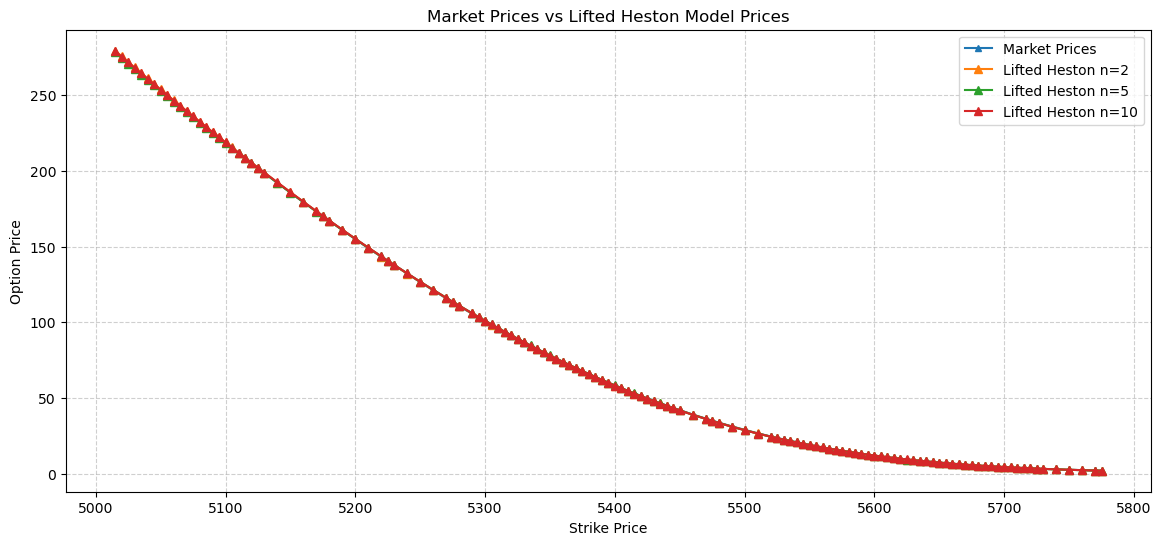

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(strikes, marketPrices, marker='^', linestyle='-', label="Market Prices", markersize=5)

model_prices = []
for idx, n in enumerate(n_values):
    rn = 1 + 10 * (n**(-0.9))
    V0, lamb, theta, nu, rho = fit[idx].params['V0'].value, fit[idx].params['lamb'].value, fit[idx].params['theta'].value, fit[idx].params['nu'].value, fit[idx].params['rho'].value
    model_prices.append(Call_Price_Lifted_Heston(S0, strikes, maturity, rho, lamb, theta, nu, V0, n, rn, alpha, M, alpha2, L))
    plt.plot(strikes, model_prices[-1], marker='^', linestyle='-', label=f'Lifted Heston n={n}')

plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Market Prices vs Lifted Heston Model Prices")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

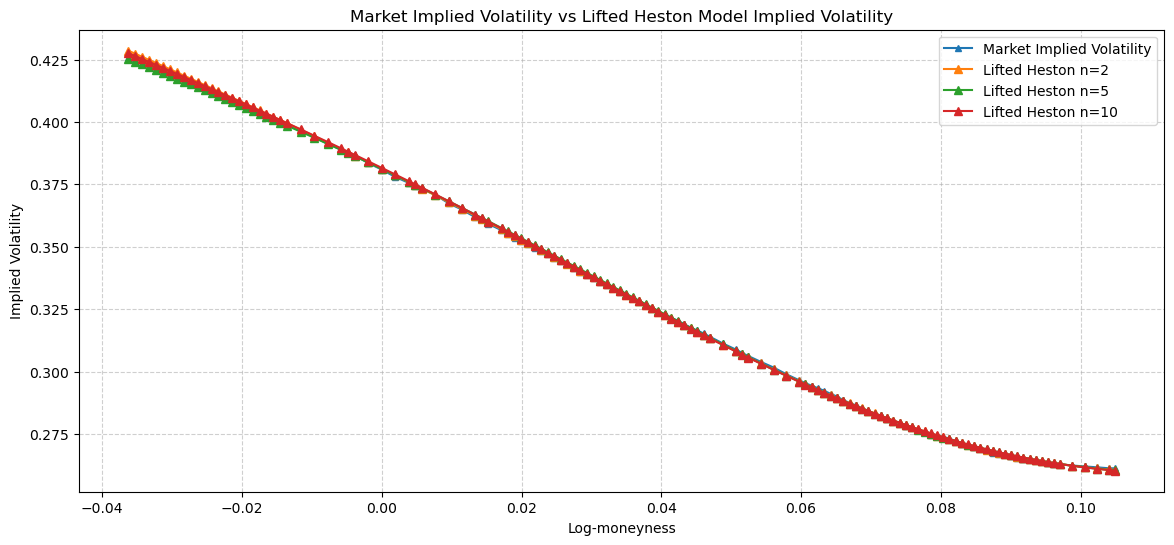

In [21]:
plt.figure(figsize=(14, 6))
iv_market = iv(marketPrices[:], S0, strikes[:], maturity, r, 'c', return_as='numpy')
plt.plot(np.log(strikes[:]/S0), iv_market, marker='^', linestyle='-', label="Market Implied Volatility", markersize=5)

ivs_lifted_heston = []
for idx, n in enumerate(n_values):
    iv_lifted_heston = iv(model_prices[idx][:], S0, strikes[:], maturity, r, 'c', return_as='numpy')
    ivs_lifted_heston.append(iv_lifted_heston)
    plt.plot(np.log(strikes[:]/S0), ivs_lifted_heston[-1], marker='^', linestyle='-', label=f'Lifted Heston n={n}')

plt.xlabel("Log-moneyness")
plt.ylabel("Implied Volatility")
plt.title("Market Implied Volatility vs Lifted Heston Model Implied Volatility")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()